In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt                        
%matplotlib inline   

The two png-files were created with the same resolution as the video: 848x480.
So for the first step no image carving, streching, etc. will be necessary.

In [103]:
#path to the video mp4 file, for the first time only one video can be read
path_video = "C:\\Users\\Snoopy\\GH_data4denoiser\\video1.mp4"
#a white rectangle, which will be used for the weighted add
path_png4weighted = "C:\\Users\\Snoopy\\GH_data4denoiser\\w4.png"
#a "watermark" writing, for full cover
path_png4add = "C:\\Users\\Snoopy\\GH_data4denoiser\\w5.png"
#folder for the outputdata
path_datafolder_pureimage = "C:\\Users\\Snoopy\\GH_data4denoiser\\pure\\"
path_datafolder_watermarked = "C:\\Users\\Snoopy\\GH_data4denoiser\\watermarked\\"

__Below:__ The first frame of the video

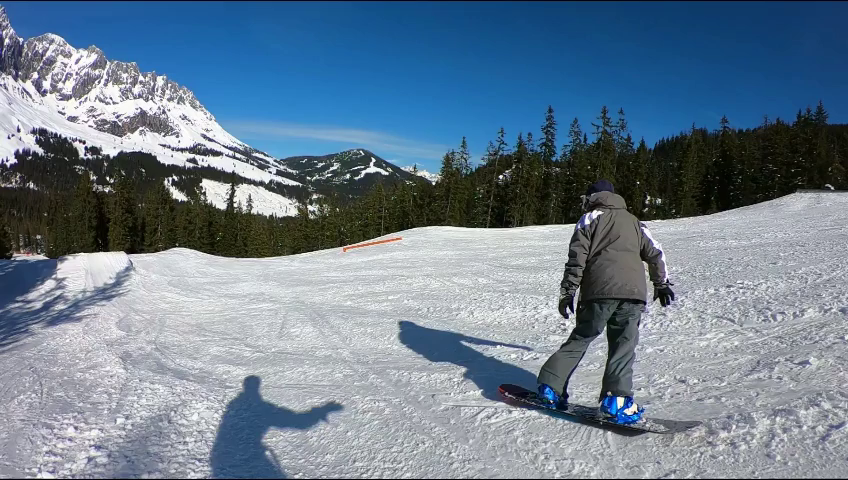

__Below:__ The first frame of the video with the noise

 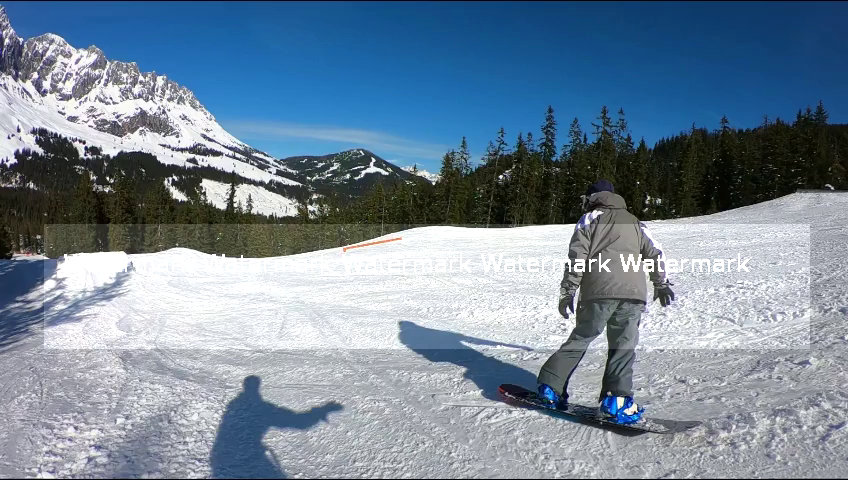

In [110]:
img_4weighted = cv2.imread(path_png4weighted)
img_wm_text = cv2.imread(path_png4add)
index = 0
cap = cv2.VideoCapture(path_video)
while(cap.isOpened()):
    index+=1
    ret, image = cap.read()
    dst = cv2.addWeighted(image,1,img_4weighted,0.15,0)
    dst = cv2.add(dst,img_wm_text)
    cv2.imwrite(path_datafolder_pureimage+"frame"+str(index)+".png",image)
    cv2.imwrite(path_datafolder_watermarked+"blend"+str(index)+".png",dst) 
    if index == 5:
        break